In [37]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

db_path = r"C:\Users\guill\OneDrive\Escritorio\MASTER EN IA\Artificial Vision\Assignment\data\TVAProject"


Evaluating on: ['01.png', '02.png', '03.png', '04.png', '05.png', '06.png', '07.png', '08.png', '09.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png']


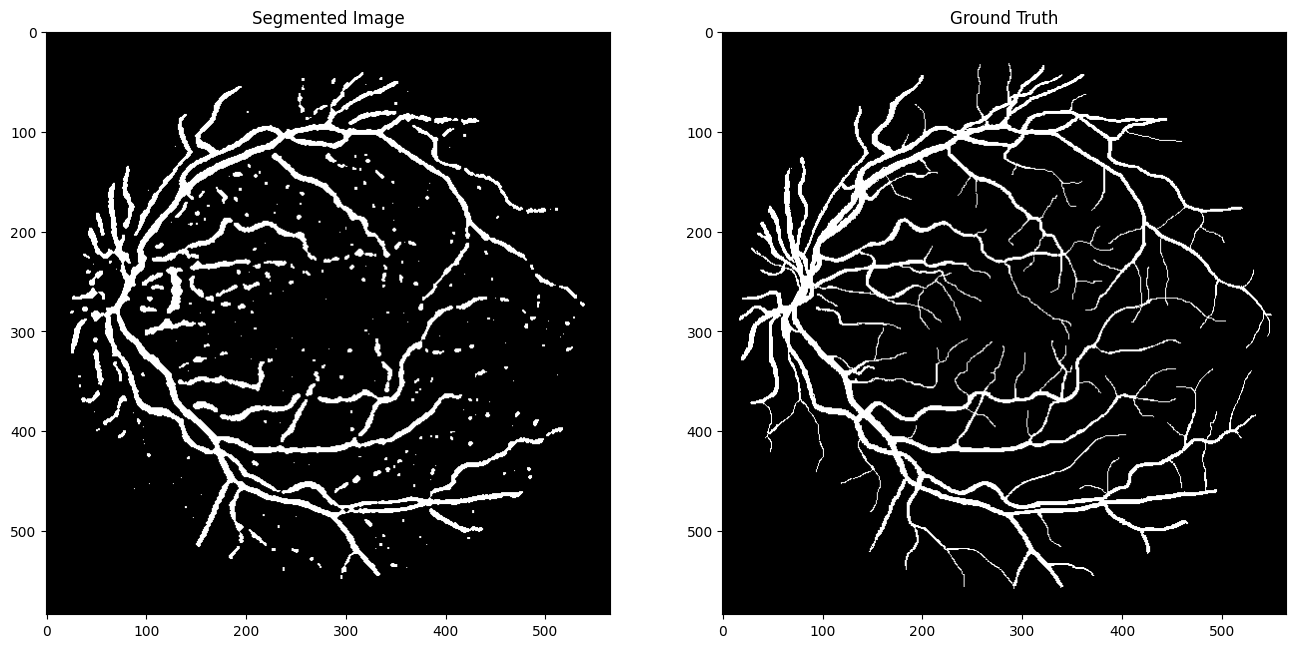

Image 01.png - IoU=0.5430


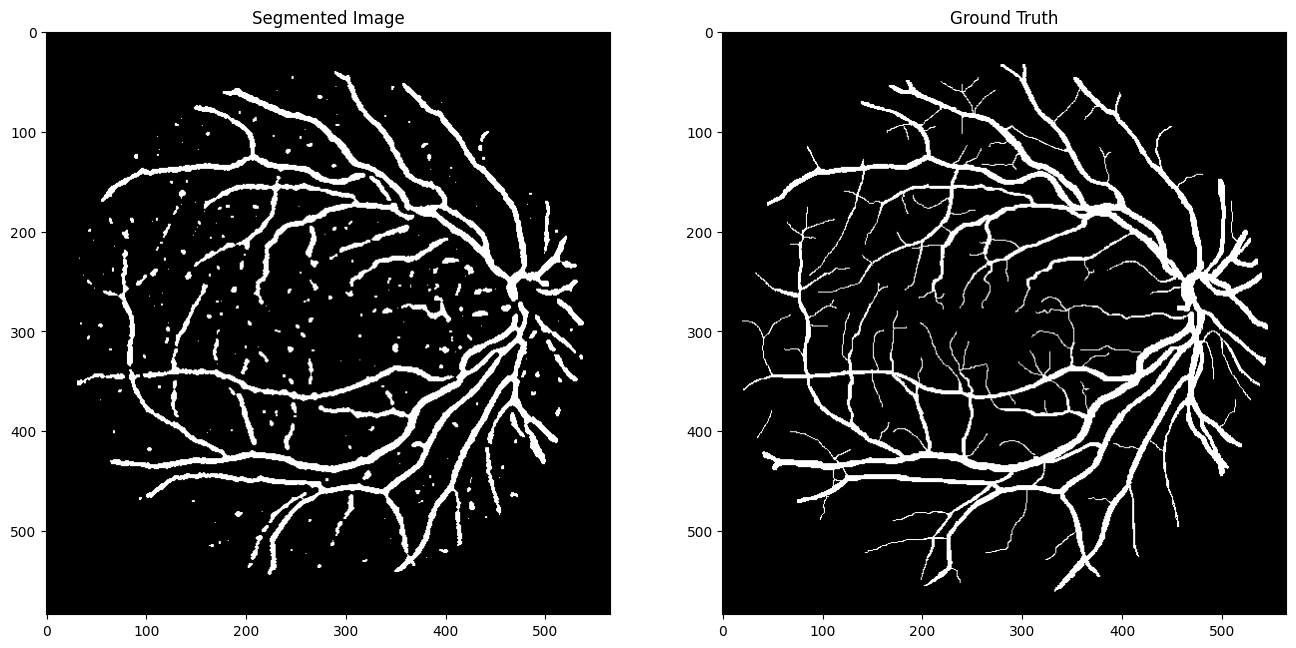

Image 02.png - IoU=0.5991


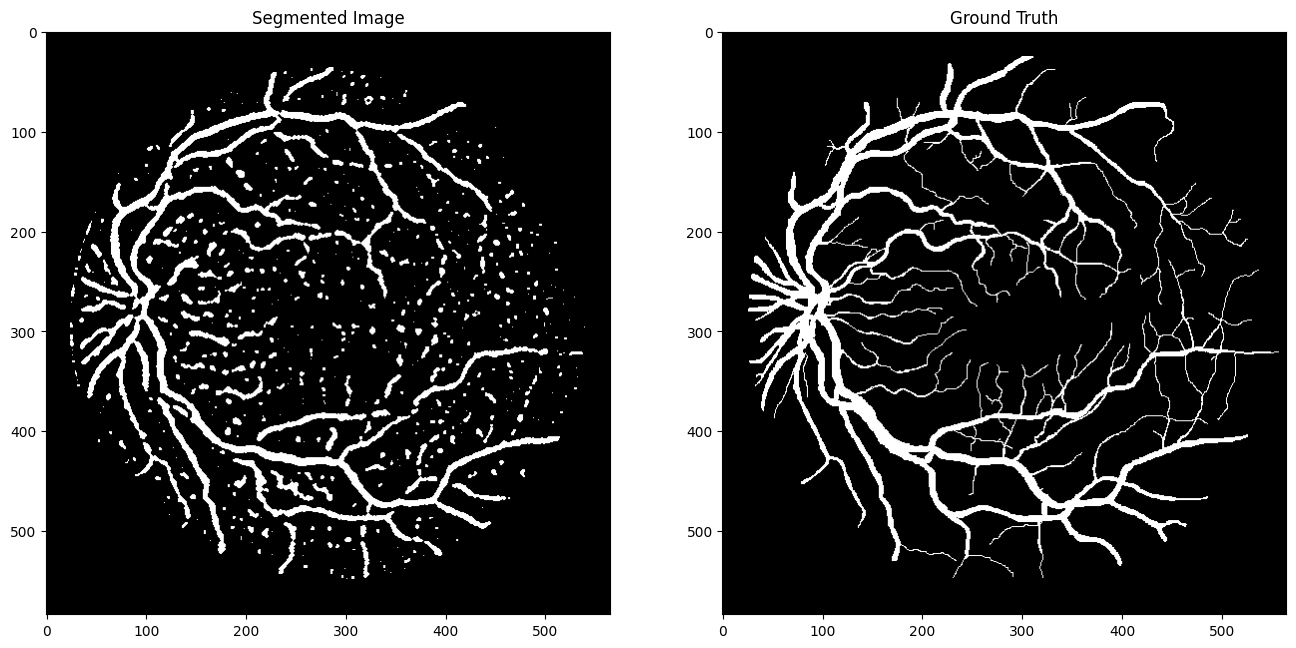

Image 03.png - IoU=0.5004


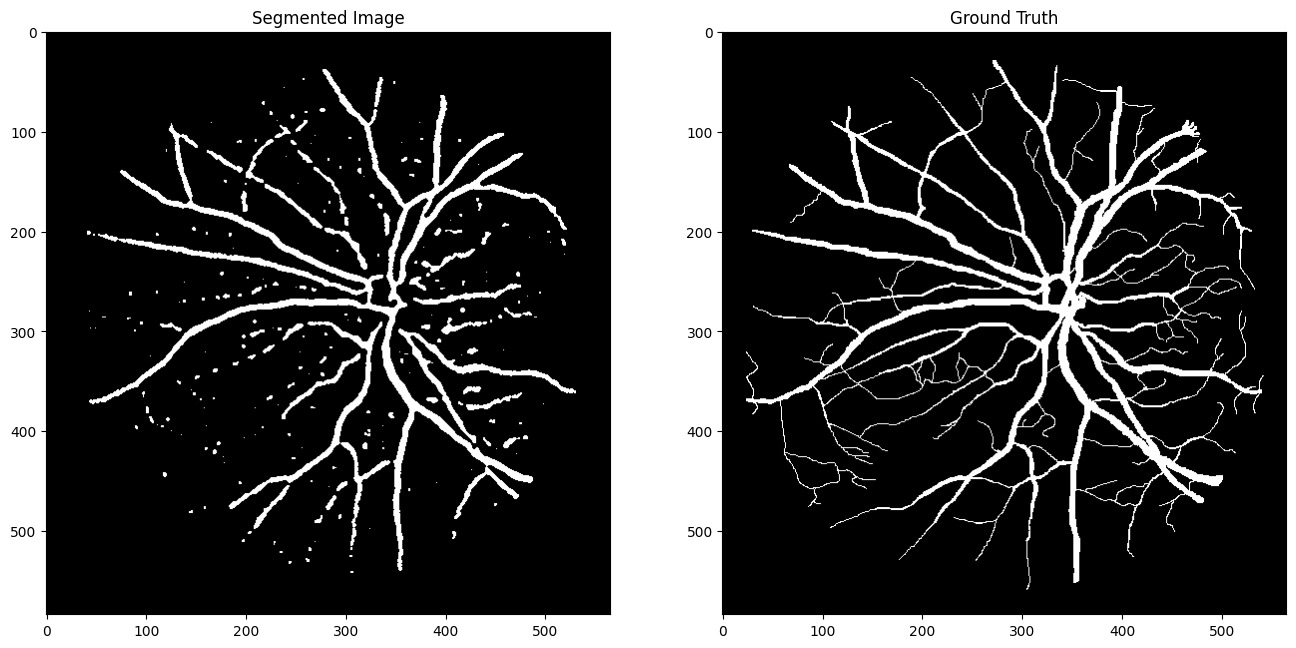

Image 04.png - IoU=0.5716


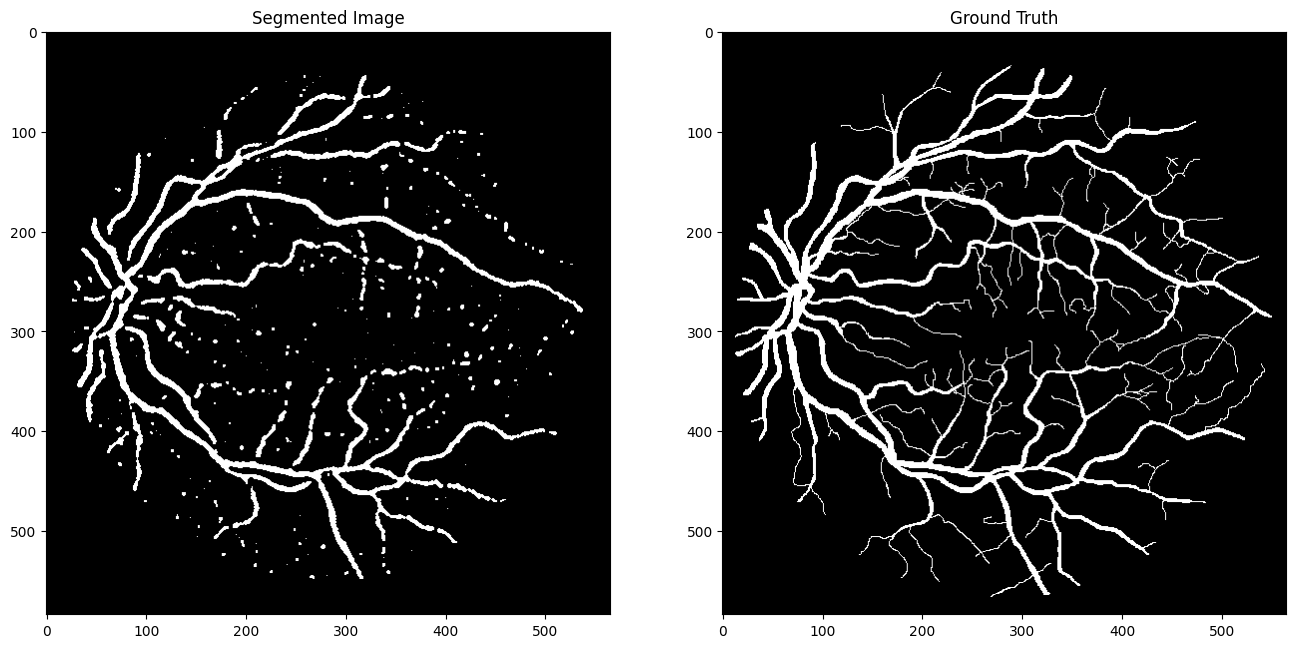

Image 05.png - IoU=0.5194


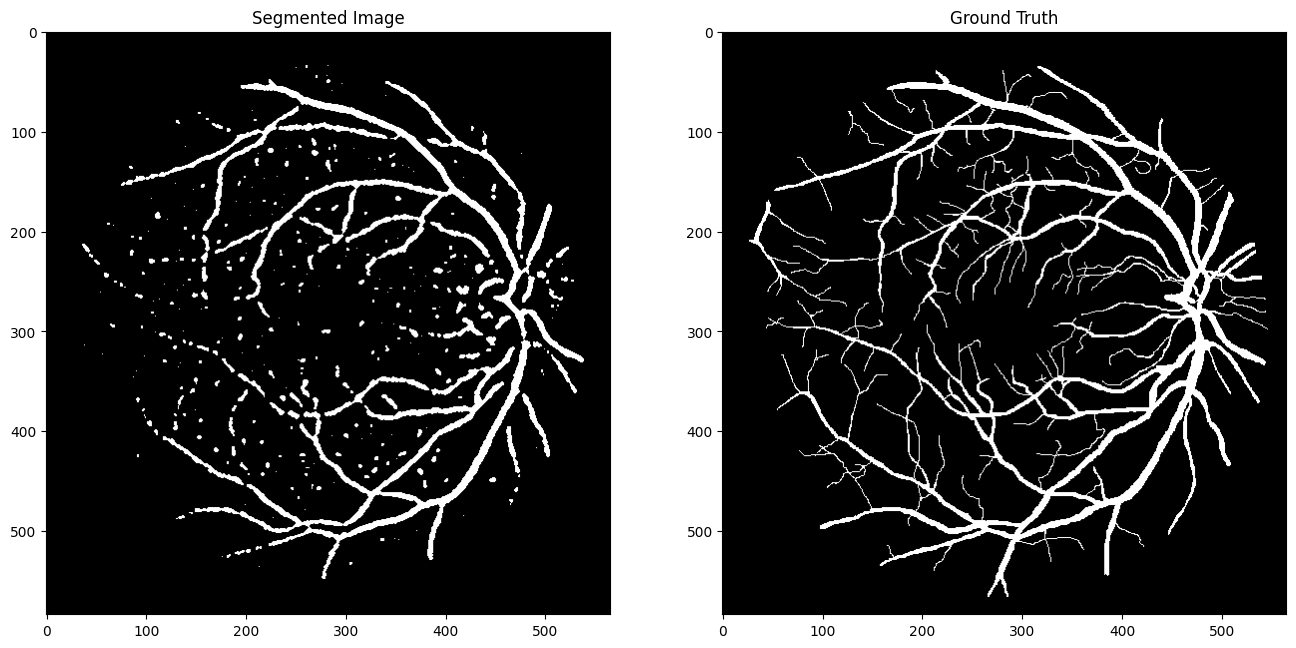

Image 06.png - IoU=0.5117


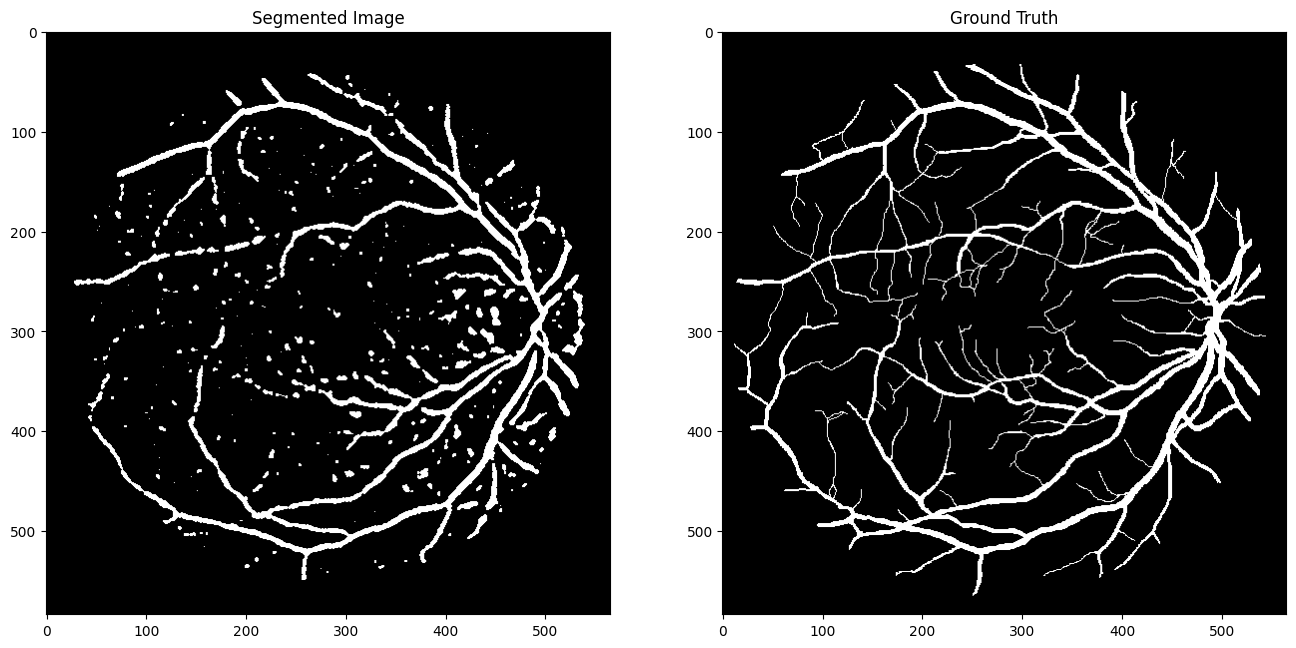

Image 07.png - IoU=0.5050


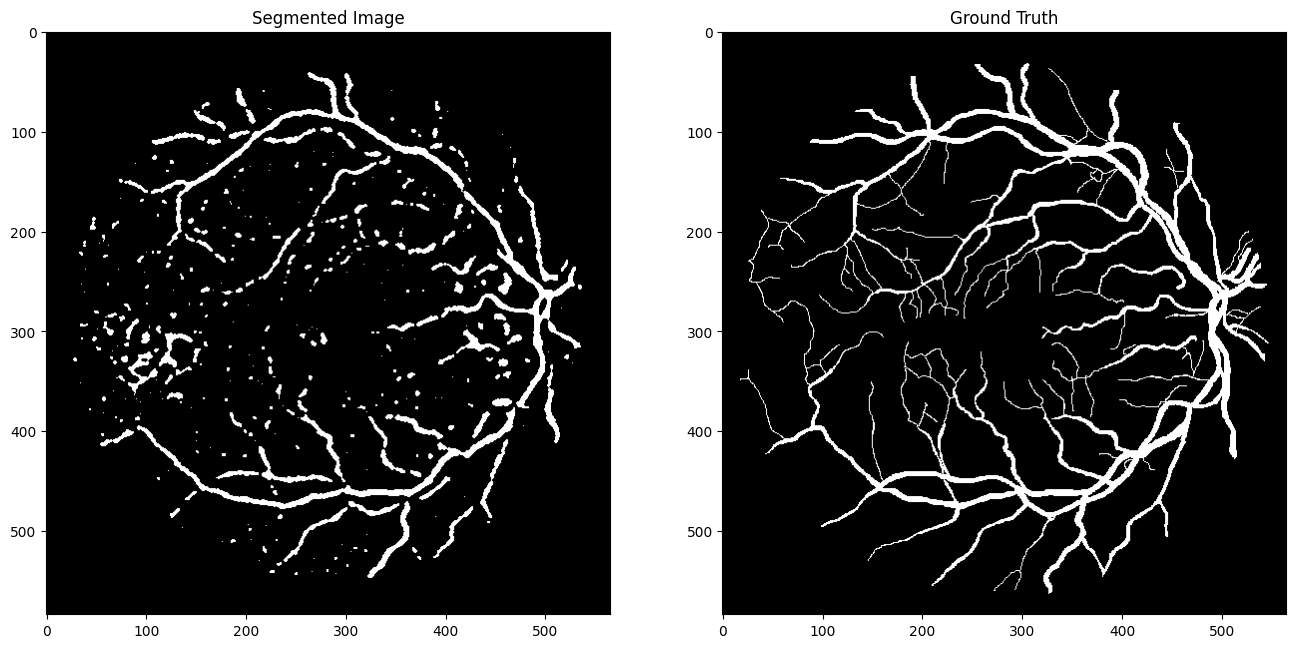

Image 08.png - IoU=0.4492


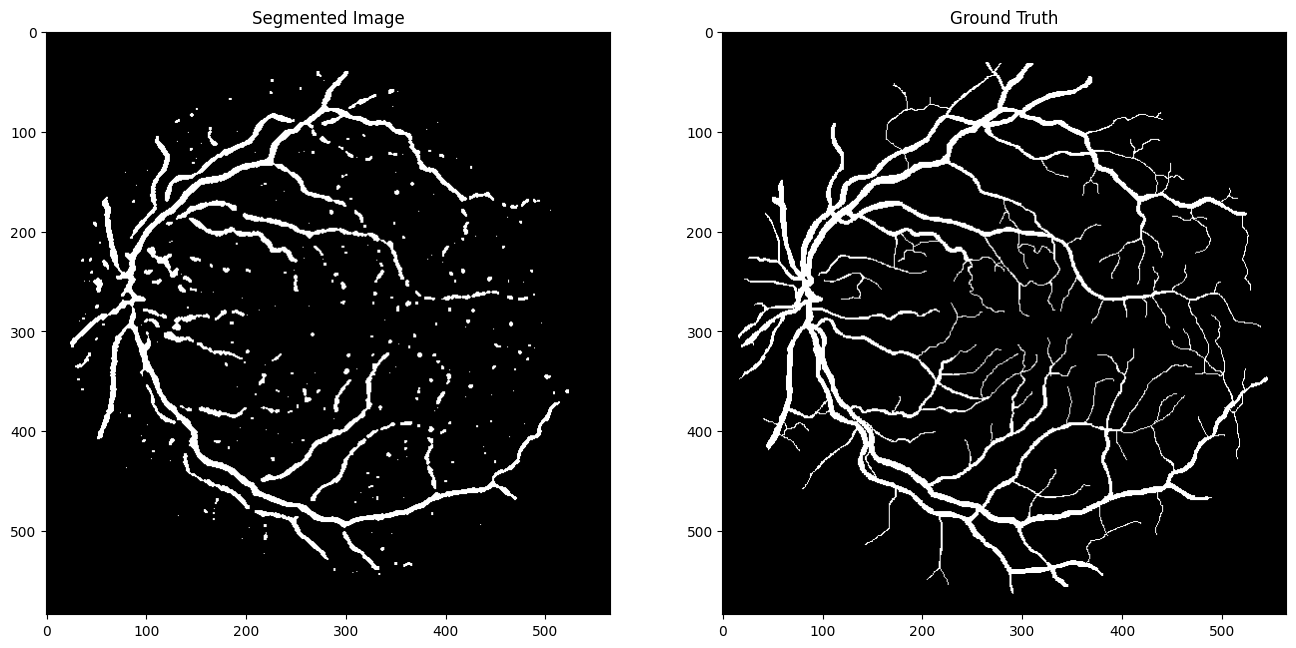

Image 09.png - IoU=0.4845


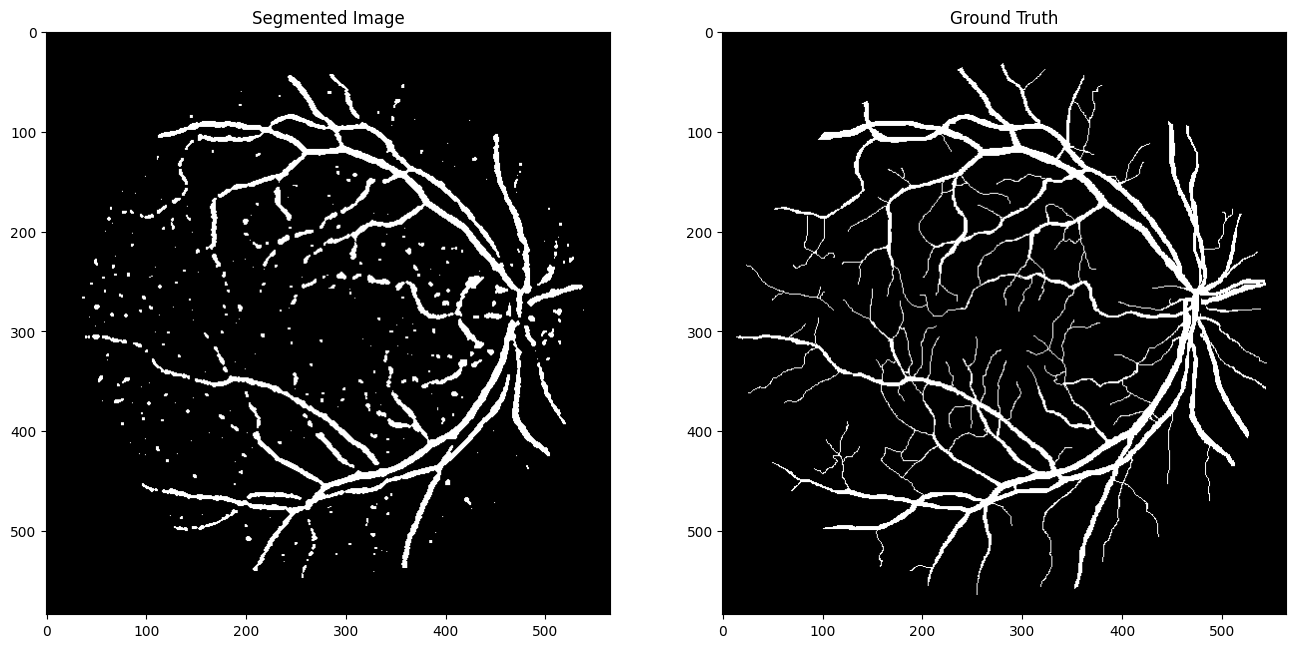

Image 10.png - IoU=0.5165


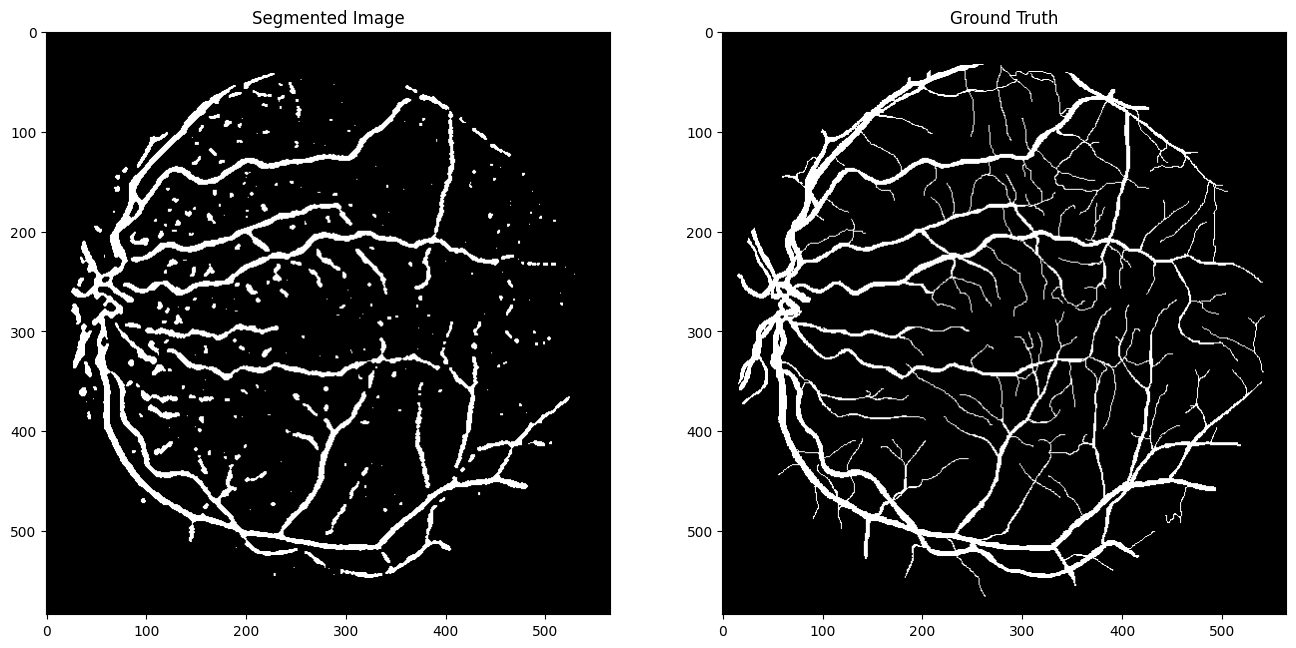

Image 11.png - IoU=0.4939


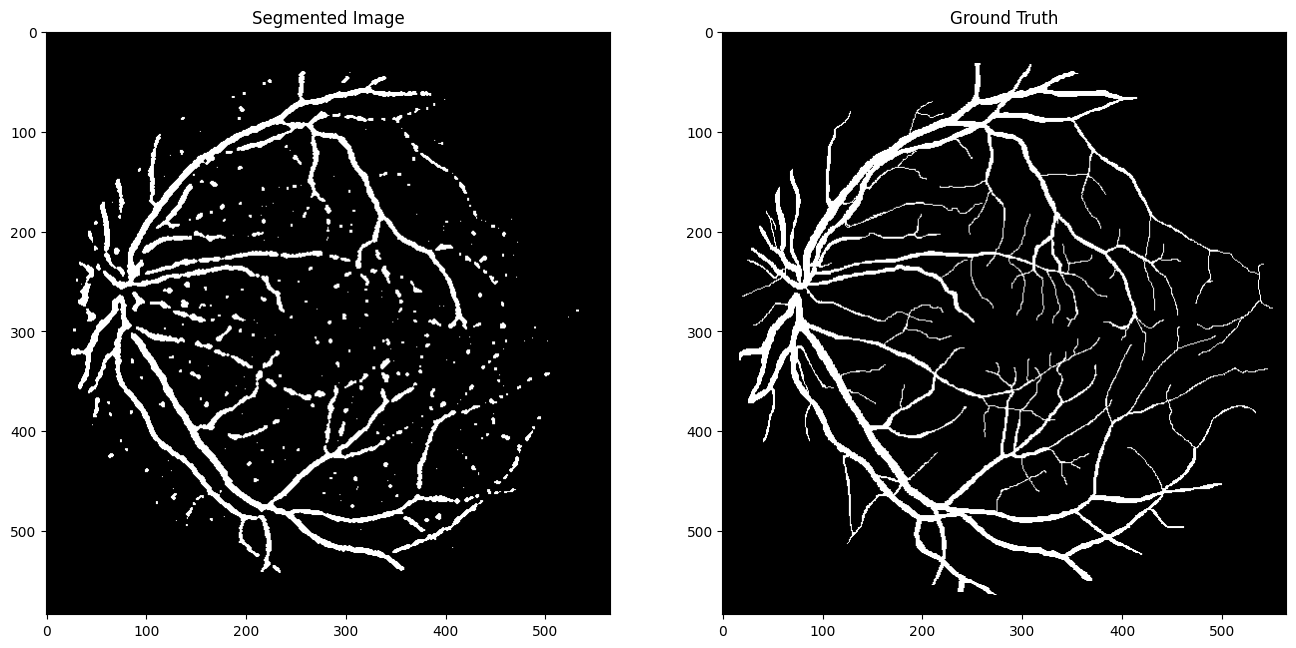

Image 12.png - IoU=0.5092


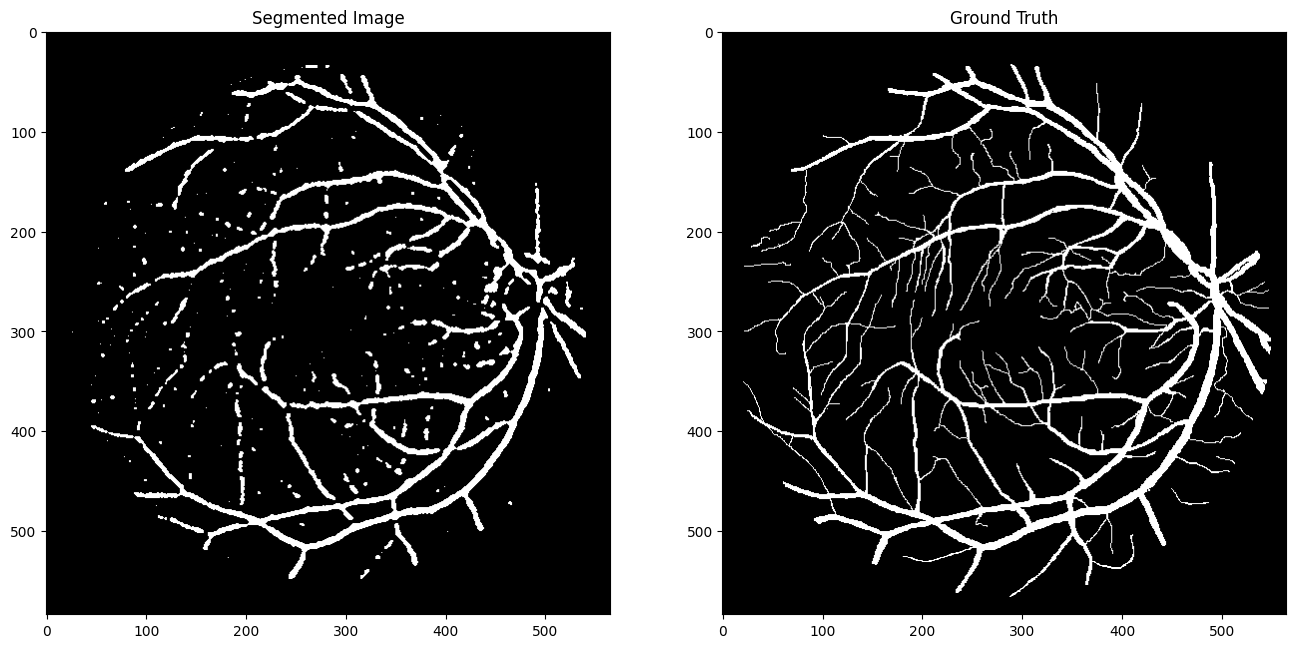

Image 13.png - IoU=0.5186


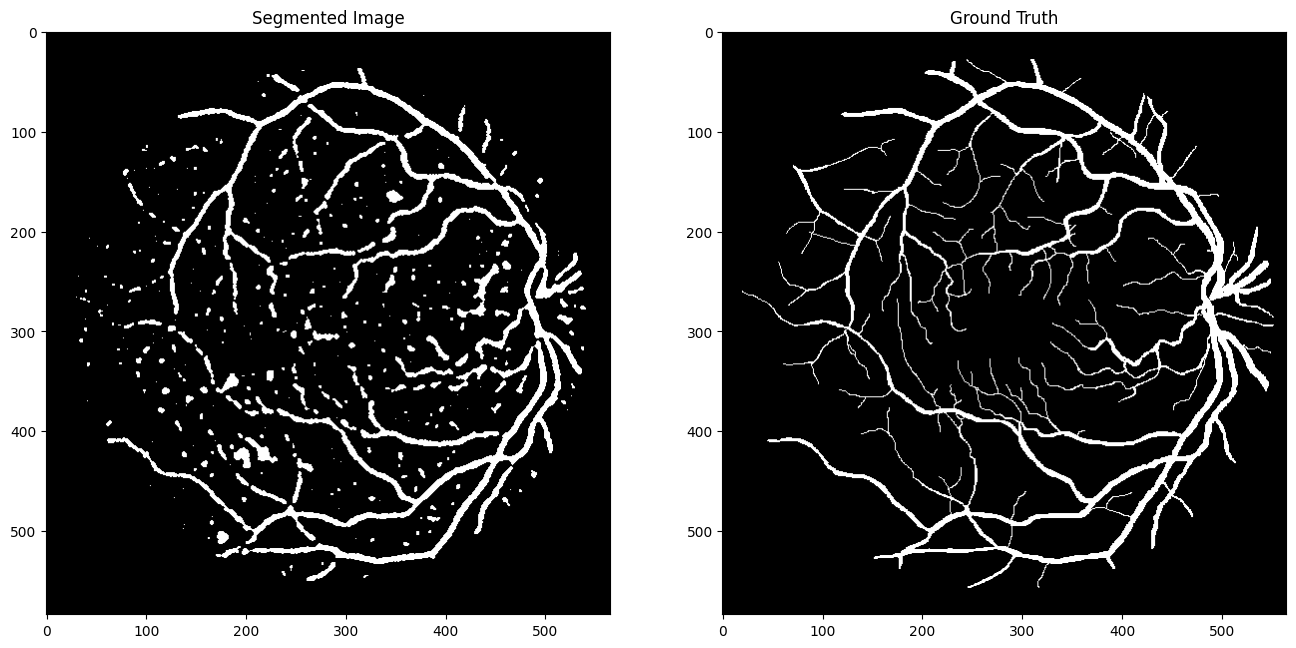

Image 14.png - IoU=0.5114


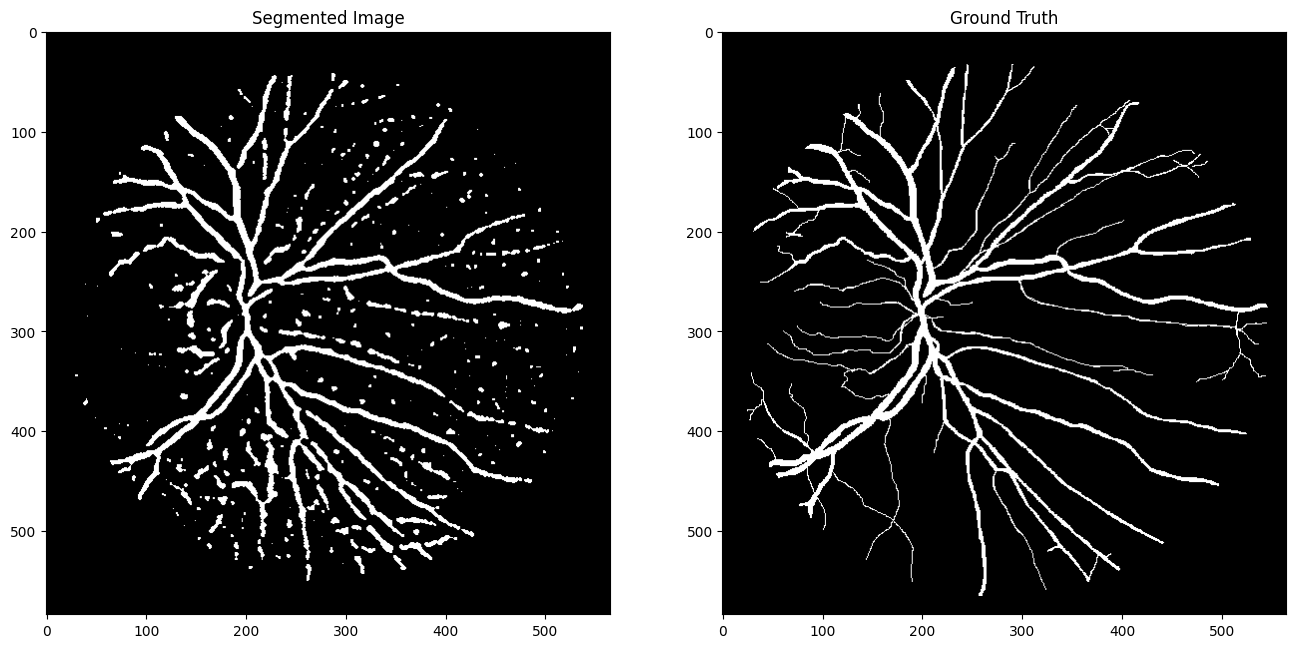

Image 15.png - IoU=0.4783


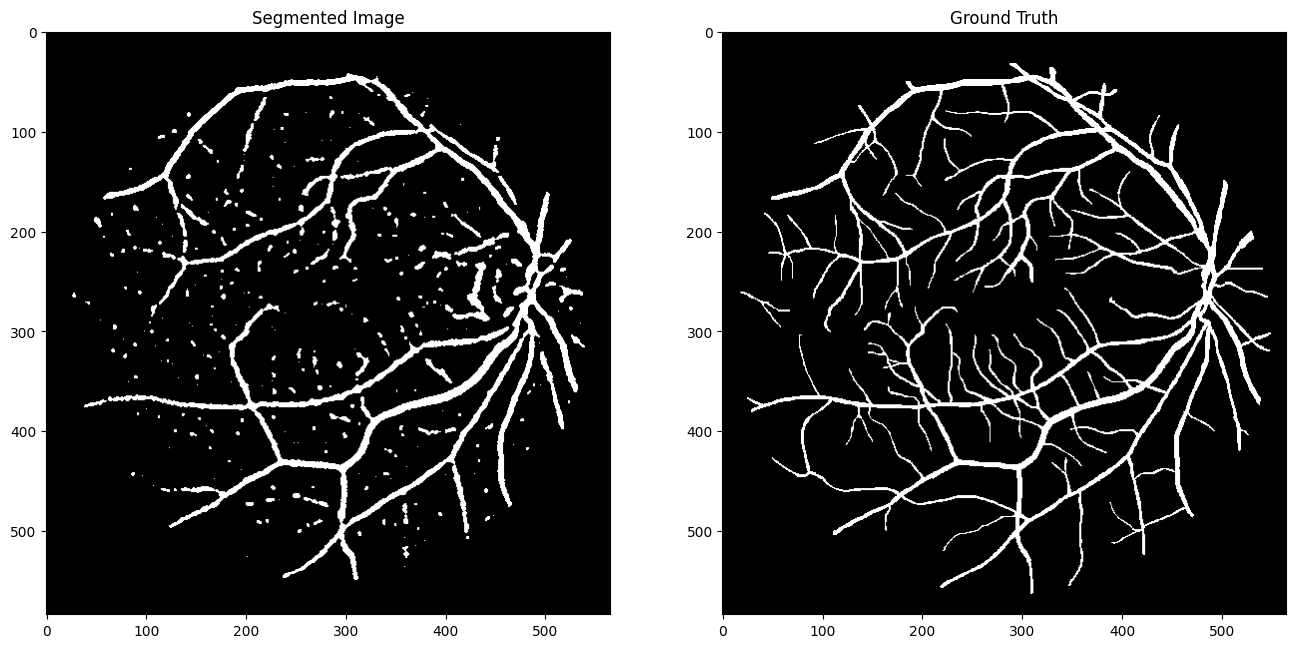

Image 16.png - IoU=0.5180


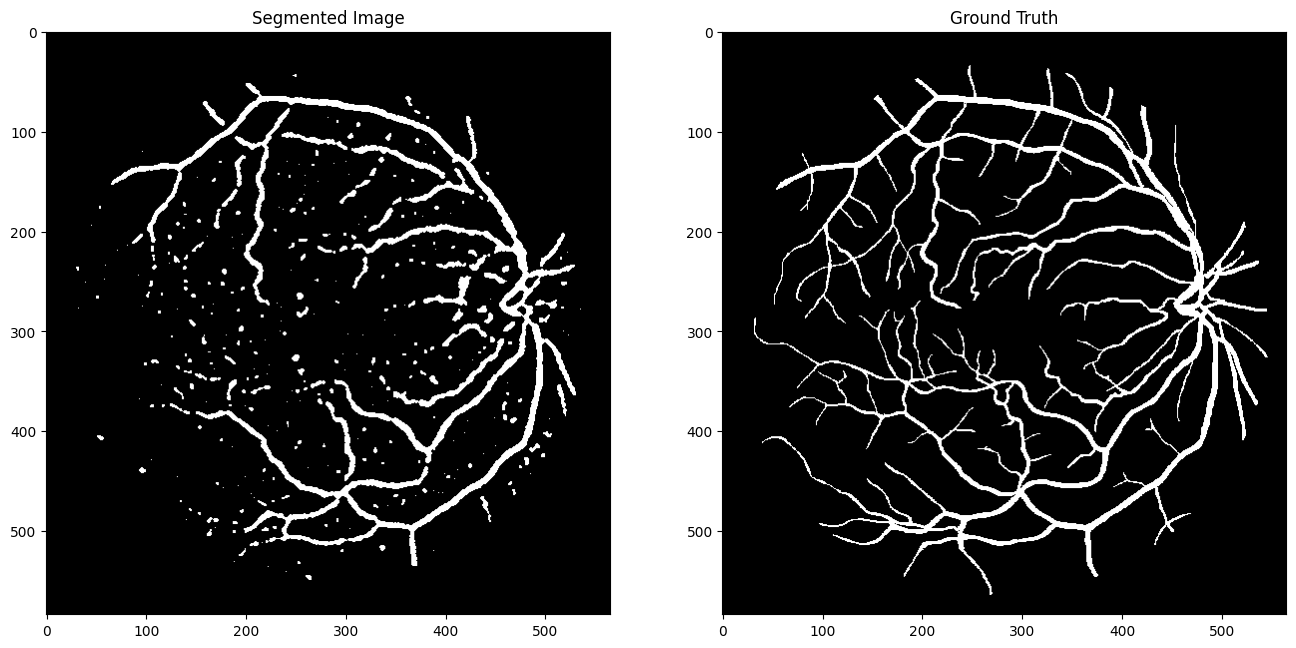

Image 17.png - IoU=0.4967


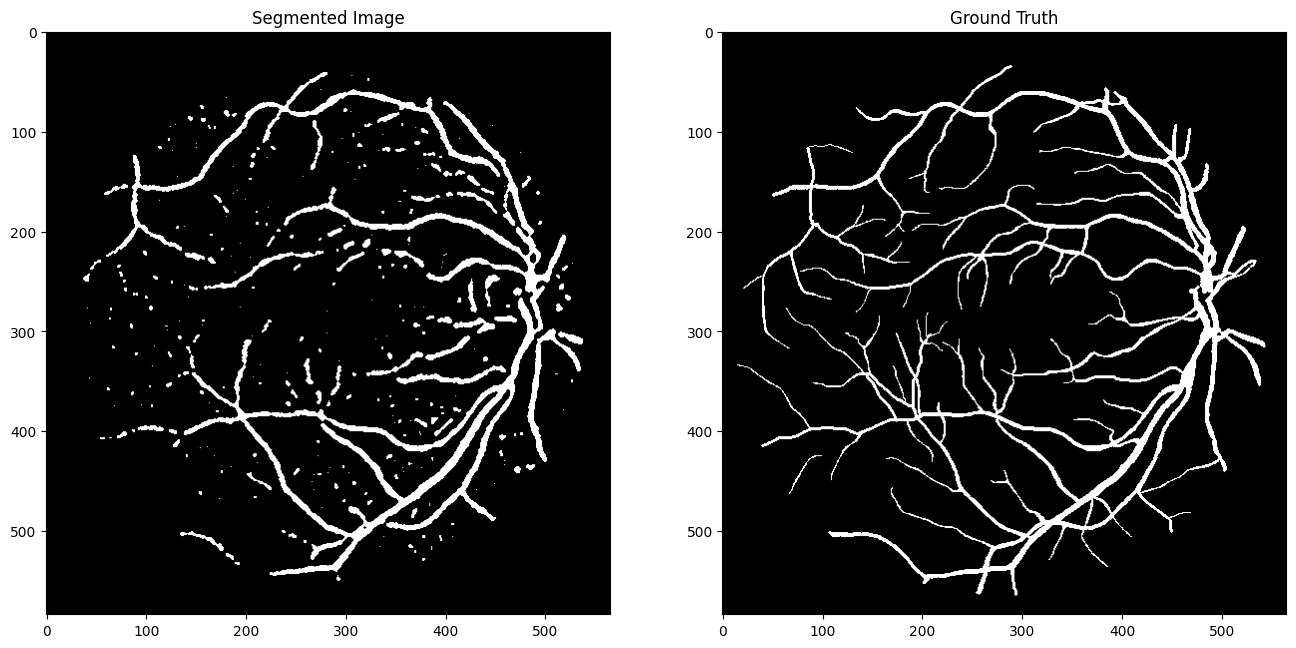

Image 18.png - IoU=0.5224


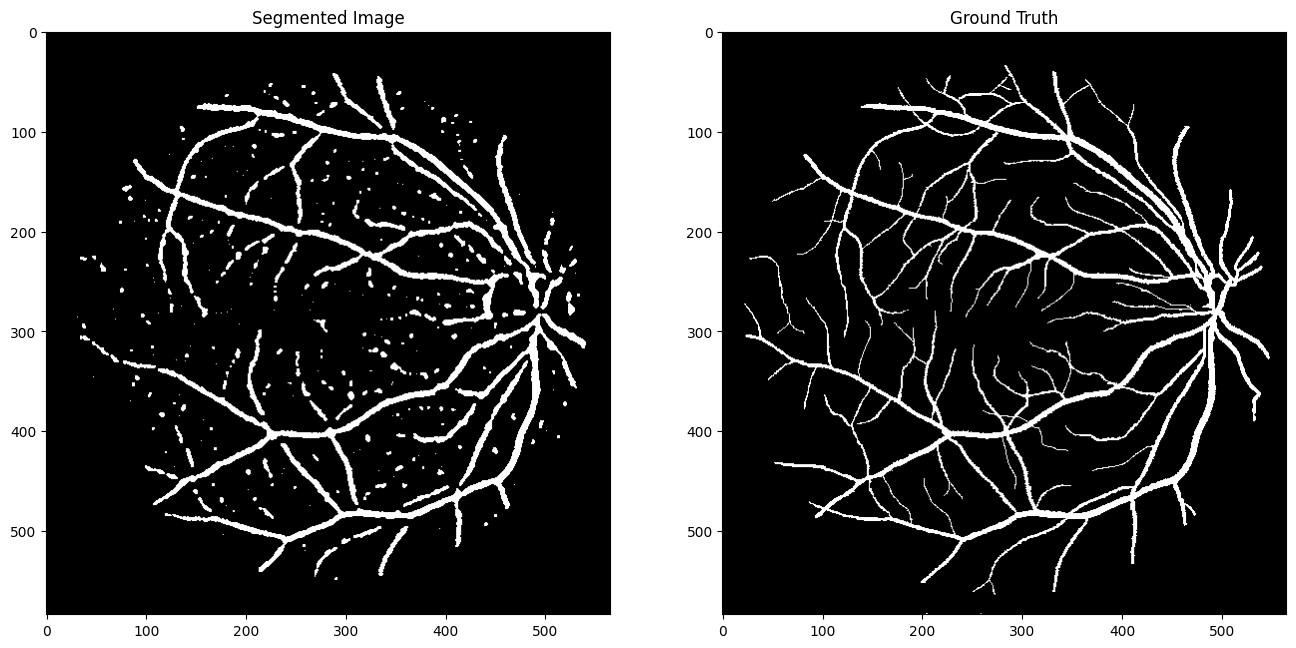

Image 19.png - IoU=0.5663


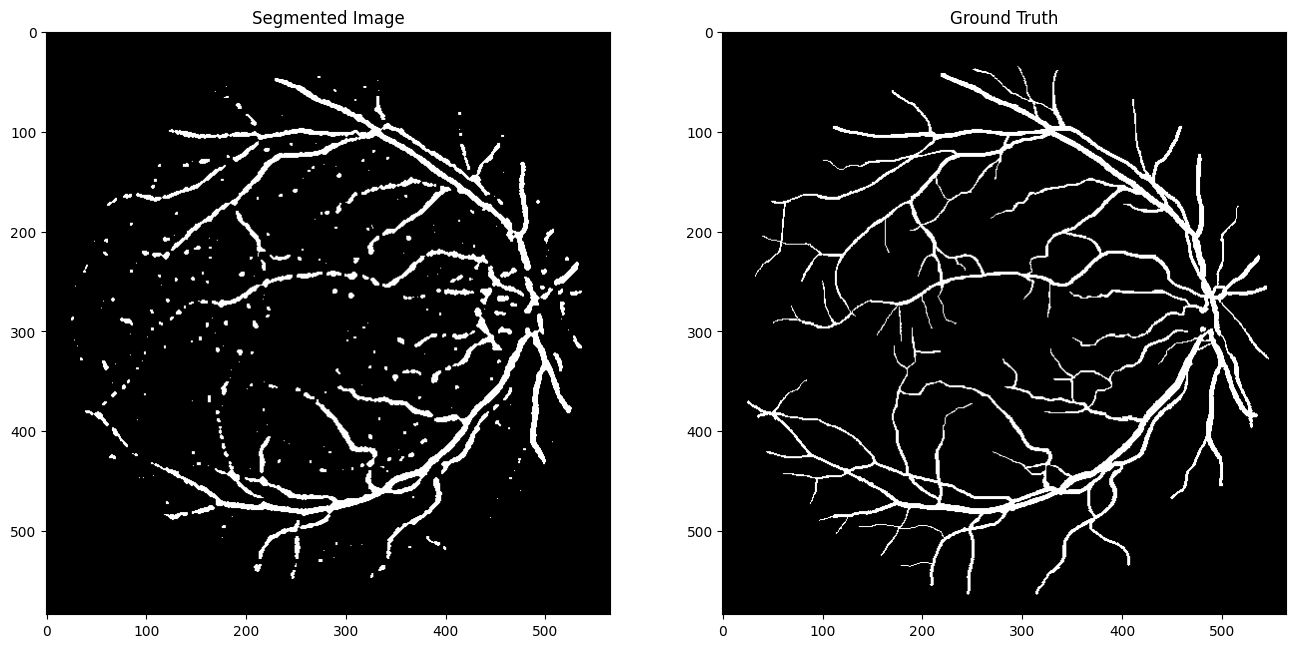

Image 20.png - IoU=0.5084
------------------------------------
Mean IoU=0.5162


In [45]:

def create_circular_mask(img_shape, radius_ratio=0.46):
    h, w = img_shape[:2]
    center = (w//2, h//2)
    radius = int(min(h, w) * radius_ratio)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv.circle(mask, center, radius, 255, -1)
    return mask

def enhanced_preprocessing(img):

    # 1) Extraer canal verde si es imagen en color
    if len(img.shape) == 3:
        green_channel = img[:, :, 1]
    else:
        green_channel = img.copy()

    gauss_kernel = 15
    blurred = cv.GaussianBlur(green_channel, (gauss_kernel, gauss_kernel), 0)


    clahe_clip = 2.2
    clahe = cv.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
    clahe_img = clahe.apply(blurred)

   
    normalized = cv.normalize(clahe_img, None, 0, 255, cv.NORM_MINMAX)

    mask = create_circular_mask(normalized.shape)

    return normalized, mask

def adaptive_thresholding(img):

    block_size = 13
    c_value = 2.5
    thresh = cv.adaptiveThreshold(
        img.astype(np.uint8), 255,
        cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY_INV,
        block_size,
        c_value
    )
    return thresh

def morphological_operations(binary_img):

    morph_kernel_size = 3
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))

   
    opened = cv.morphologyEx(binary_img, cv.MORPH_OPEN, kernel)

    closed = cv.morphologyEx(opened, cv.MORPH_CLOSE, kernel)

 
    final_blur_size = 3
    smoothed = cv.GaussianBlur(closed, (final_blur_size, final_blur_size), 0)


    _, final_result = cv.threshold(smoothed, 128, 255, cv.THRESH_BINARY)
    return final_result

def vessel_segmentation(img_path):

    # 1) Leer imagen
    img = cv.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {img_path}")

    # 2) Preprocesamiento
    preprocessed, circle_mask = enhanced_preprocessing(img)

    # 3) Umbralización adaptativa
    binary = adaptive_thresholding(preprocessed)

    # 4) Aplicar la máscara circular
    masked = cv.bitwise_and(binary, binary, mask=circle_mask)

    # 5) Morfología final
    final_seg = morphological_operations(masked)

    return final_seg


def single_IoU(img_name):

    # Construir ruta de la imagen y segmentarla
    input_img = os.path.join(db_path, 'input', img_name)
    obtained = vessel_segmentation(input_img)

    # Cargar ground truth (convertir a 0/1)
    path_target = os.path.join(db_path, 'gt', img_name)
    solution = cv.imread(path_target, cv.IMREAD_GRAYSCALE)
    if solution is None:
        print(f"No se pudo leer GT: {path_target}")
        return 0.0
    solution = solution // 255

    # Mostrar resultados
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.title("Segmented Image")
    plt.imshow(obtained, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Ground Truth")
    plt.imshow(solution, cmap='gray')
    plt.show()

    # Cálculo de IoU (intersection over union)
    intersectionAB = np.logical_and(obtained, solution).sum()
    unionAB        = np.logical_or(obtained, solution).sum()
    score = intersectionAB / unionAB if unionAB > 0 else 0
    print(f"Image {img_name} - IoU={score:.4f}")

    return score

def evaluate_segmentation():
   
    # Listar imágenes en db_path/input
    path_input = os.path.join(db_path, 'input')
    imgs = [f for f in os.listdir(path_input) if f.endswith('.png')]
    print("Evaluating on:", imgs)

    meanIoU = 0.0
    total_images = len(imgs)

    for img in imgs:
        meanIoU += single_IoU(img)

    meanIoU /= total_images if total_images > 0 else 1
    print("------------------------------------")
    print(f"Mean IoU={meanIoU:.4f}")


if __name__ == "__main__":
    evaluate_segmentation()
